In [1]:
# Move into the proper directory
# Must input home directory of the "NeutronSpectraGeneration" folder
import os
os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn')


In [2]:
import data_generation
import constants
from constants import Ebins

In [3]:
import fruit_spectra
fruit_spectra.randFission()
fruit_spectra.randGauss()
fruit_spectra.randHighEnergy()
fruit_spectra.randEvap()
from fruit_spectra import randFission, randGauss, randHighEnergy, randEvap
from fruit_spectra import P_th_fission, P_e_fission, b_fission, beta_p_fission, alpha_fission, beta_fission
from fruit_spectra import P_th_gauss, P_e_gauss, b_gauss, beta_p_gauss, E_m_gauss, sigma_gauss
from fruit_spectra import P_th_high_energy, P_e_high_energy, P_f_high_energy, b_high_energy, beta_p_high_energy, T_ev_high_energy, T_hi_high_energy


In [4]:
T_0 = 2.53e-8
E_d = 7.07e-8

In [5]:

def thermal(E, T_0):
    spectra = ( (E / (np.power(T_0, 2)))*np.exp(-E/T_0) )
    return spectra / np.sum(spectra)

def epithermal(E, E_d, b, beta_p):
    spectra = ( (1 - np.exp( -np.power((E/E_d), 2) )) * np.power(E, (b-1)) * np.exp(-E/beta_p) )
    return spectra / np.sum(spectra)
    
def fast_fission(E, alpha, beta):
    spectra = (np.power(E, alpha)) * np.exp(-E / beta)
    return spectra / np.sum(spectra)

def fast_evaporation(E, T_ev):
    spectra = (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev) 
    return spectra / np.sum(spectra)

def fast_gaussian(E, E_m, sigma):
    spectra = np.exp( - np.power((E - E_m), 2) / (2 * np.power((sigma * E_m), 2) ) )
    return spectra / np.sum(spectra)

def fast_high_energy(E, T_ev):
    spectra = (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev)
    return spectra / np.sum(spectra)

def high_energy_func(E, T_hi):
    spectra = (E / (np.power(T_hi, 2))) * np.exp(-E / T_hi)
    return spectra / np.sum(spectra)


In [6]:
def fission(E, P_th, P_e, b, beta_p, alpha, beta):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_fission(E, alpha, beta)
    return spectra

def evaporation(E, P_th, P_e, b, beta_p, T_ev):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_evaporation(E, T_ev)
    return spectra

def gaussian(E, P_th, P_e, b, beta_p, E_m, sigma):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_gaussian(E, E_m, sigma)
    return spectra

def high_energy(E, P_th, P_e, P_f, b, beta_p, T_ev, T_hi):
    E = E * 1e-6
    while P_th + P_e + P_f > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
        P_f = P_f / 2.0
    P_he = 1 - (P_th + P_e + P_f)
    
    if T_hi < T_ev:
        T_hi = 10**(np.log10(T_ev / T_hi))
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_high_energy(E, T_ev) + P_he * high_energy_func(E, T_hi)
    return spectra



In [7]:
import sys
sys.path.append('./FRUIT')
import fruit_fittings

import data_generation
import constants

import random

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [8]:
YMAX = 1
def plot_loghist(ax, x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    weights = np.ones_like(x) / len(x)
    ax.hist(x, bins=logbins, weights=weights)
    ax.set_xscale('log')
    ax.set_ylim(0,YMAX)

def plot_hist(ax, x, bins, range):
    weights = np.ones_like(x) / len(x)
    ax.hist(x, bins=bins, range = range, weights = weights)
    ax.set_ylim(0,YMAX)
    return

fittings = fruit_fittings.FRUIT_FITTINGS

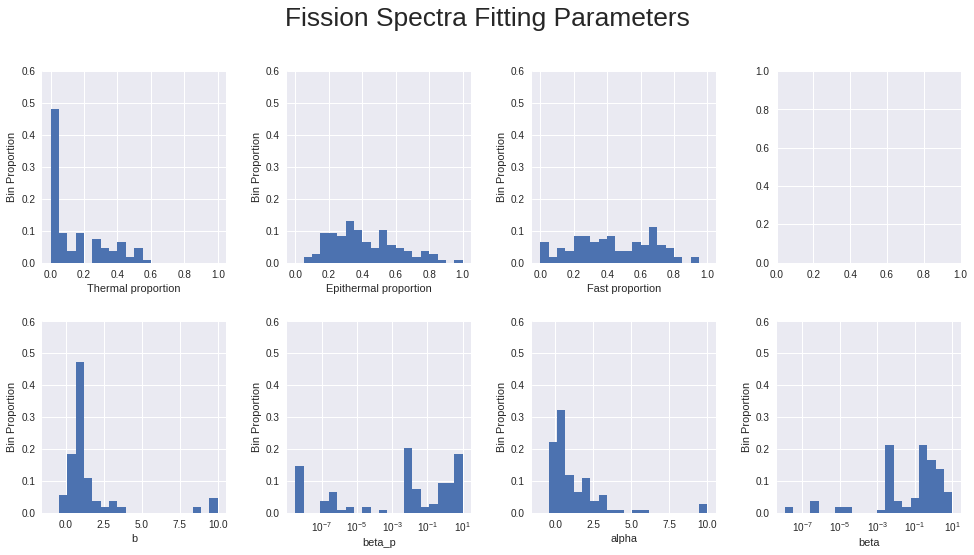

In [9]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
BINS = 20

YMAX = 0.6

plot_hist(axs[0][0], P_th_fission, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("Thermal proportion")
axs[0][0].set_ylabel("Bin Proportion")

plot_hist(axs[0][1], P_e_fission, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("Epithermal proportion")
axs[0][1].set_ylabel("Bin Proportion")

P_f_fission = np.ones(len(P_th_fission)) - (np.array(P_th_fission) + np.array(P_e_fission))
plot_hist(axs[0][2], P_f_fission, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("Fast proportion")
axs[0][2].set_ylabel("Bin Proportion")

plot_hist(axs[1][0], b_fission, bins = BINS, range = (-1, 10))
axs[1][0].set_xlabel("b")
axs[1][0].set_ylabel("Bin Proportion")

plot_loghist(axs[1][1], beta_p_fission, bins = BINS)
axs[1][1].set_xlabel("beta_p")
axs[1][1].set_ylabel("Bin Proportion")

plot_hist(axs[1][2], alpha_fission, bins = BINS, range = (-1, 10))
axs[1][2].set_xlabel("alpha")
axs[1][2].set_ylabel("Bin Proportion")

plot_loghist(axs[1][3], beta_fission, bins = BINS)
axs[1][3].set_xlabel("beta")
axs[1][3].set_ylabel("Bin Proportion")

fig.suptitle("Fission Spectra Fitting Parameters")
plt.tight_layout()

plt.savefig("FissionParams.png", dpi = 300)


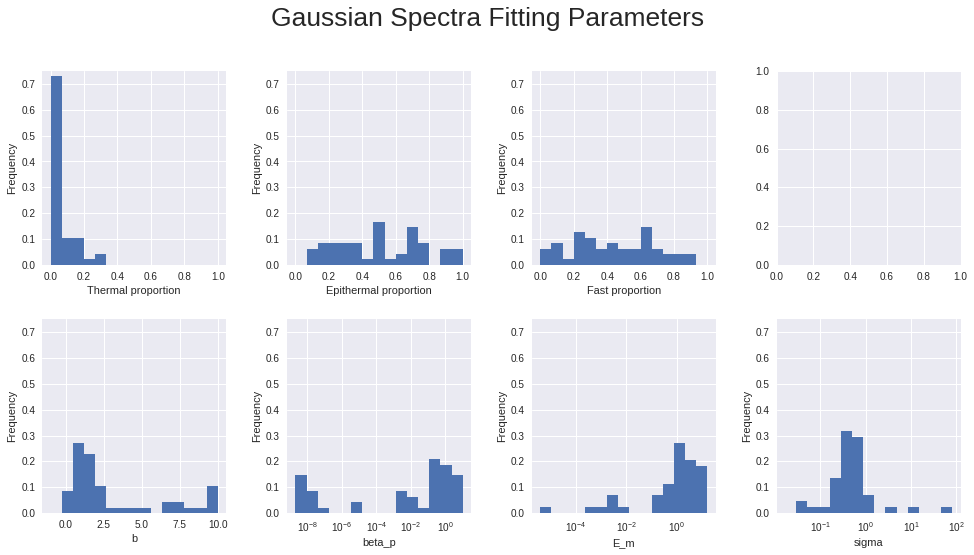

In [11]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
BINS = 15
YMAX = 0.75

plot_hist(axs[0][0], P_th_gauss, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("Thermal proportion")
axs[0][0].set_ylabel("Frequency")

plot_hist(axs[0][1], P_e_gauss, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("Epithermal proportion")
axs[0][1].set_ylabel("Frequency")

P_f_gauss = np.ones(len(P_e_gauss)) - (np.array(P_th_gauss) + np.array(P_e_gauss))
plot_hist(axs[0][2], P_f_gauss, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("Fast proportion")
axs[0][2].set_ylabel("Frequency")

plot_hist(axs[1][0], b_gauss, bins = BINS, range = (-1, 10))
#axs[1][0].hist(b_gauss, bins = BINS, range = (0, 2))
axs[1][0].set_xlabel("b")
axs[1][0].set_ylabel("Frequency")

plot_loghist(axs[1][1], beta_p_gauss, bins = BINS)
#axs[1][1].hist(beta_p_gauss, bins = BINS, range = (0, 2))
axs[1][1].set_xlabel("beta_p")
axs[1][1].set_ylabel("Frequency")

plot_loghist(axs[1][2], E_m_gauss, bins = BINS)
#axs[1][2].hist(E_m_gauss, bins = BINS, range = (0, 100))
axs[1][2].set_xlabel("E_m")
axs[1][2].set_ylabel("Frequency")

plot_loghist(axs[1][3], sigma_gauss, bins = BINS)
#axs[1][3].hist(sigma_gauss, bins = BINS, range = (0, 100))
axs[1][3].set_xlabel("sigma")
axs[1][3].set_ylabel("Frequency")

fig.suptitle("Gaussian Spectra Fitting Parameters")
plt.tight_layout()

plt.savefig("GaussianParams.png", dpi = 300)


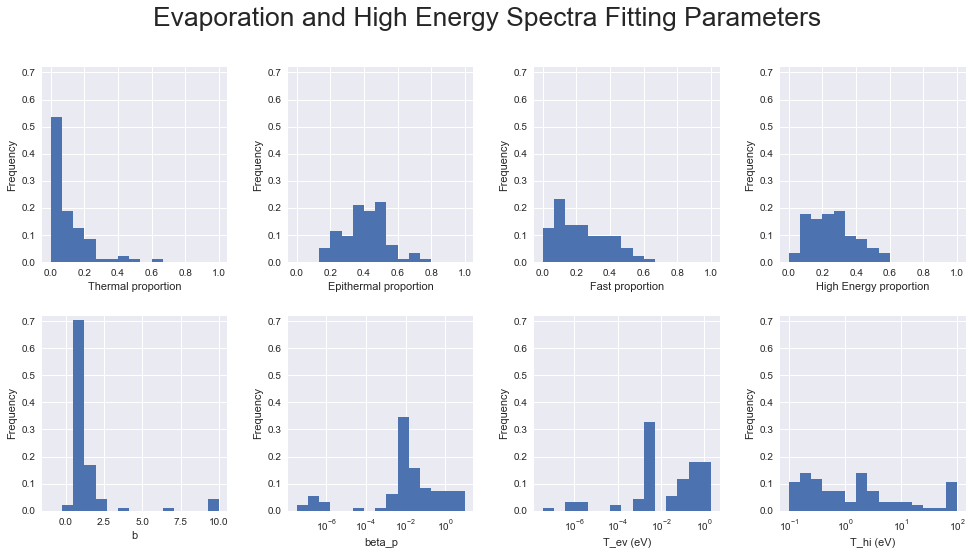

In [16]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
BINS = 15
YMAX = 0.72

plot_hist(axs[0][0], P_th_high_energy, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("Thermal proportion")
axs[0][0].set_ylabel("Frequency")

plot_hist(axs[0][1], P_e_high_energy, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("Epithermal proportion")
axs[0][1].set_ylabel("Frequency")

plot_hist(axs[0][2], P_f_high_energy, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("Fast proportion")
axs[0][2].set_ylabel("Frequency")

P_hi_high_energy = np.ones(len(P_f_high_energy)) - (np.array(P_th_high_energy) + np.array(P_e_high_energy) + np.array(P_f_high_energy))
plot_hist(axs[0][3], P_hi_high_energy, bins = BINS, range = (0,1))
axs[0][3].set_xlabel("High Energy proportion")
axs[0][3].set_ylabel("Frequency")

plot_hist(axs[1][0], b_high_energy, bins = BINS, range = (-1, 10))
axs[1][0].set_xlabel("b")
axs[1][0].set_ylabel("Frequency")

plot_loghist(axs[1][1], beta_p_high_energy, bins = BINS)
axs[1][1].set_xlabel("beta_p")
axs[1][1].set_ylabel("Frequency")

plot_loghist(axs[1][2], T_ev_high_energy, bins = BINS)
axs[1][2].set_xlabel("T_ev (eV)")
axs[1][2].set_ylabel("Frequency")

plot_loghist(axs[1][3], T_hi_high_energy, bins = BINS)
axs[1][3].set_xlabel("T_hi (eV)")
axs[1][3].set_ylabel("Frequency")

fig.suptitle("Evaporation and High Energy Spectra Fitting Parameters")
plt.tight_layout()

plt.savefig("EvapHighEnergyParams.png", dpi = 300)


Text(0.5, 0.98, 'Fission')

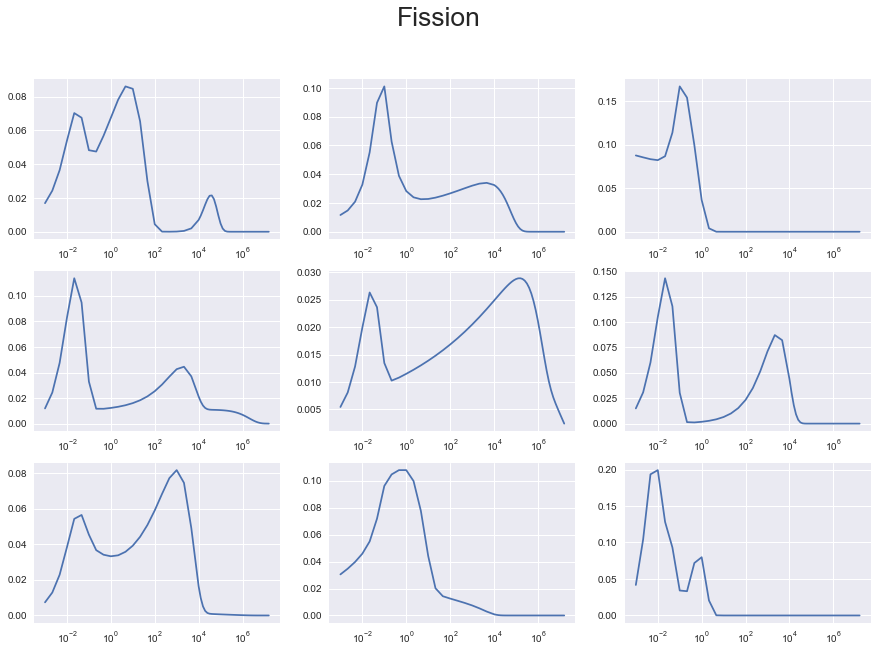

In [44]:
fig, axs = plt.subplots(3,3,figsize=(15,10))
for row in axs:
    for ax in row:
        ax.plot(Ebins, randFission())
        ax.set_xscale("log")
        
plt.suptitle("Fission")

Text(0.5, 0.98, 'Gauss')

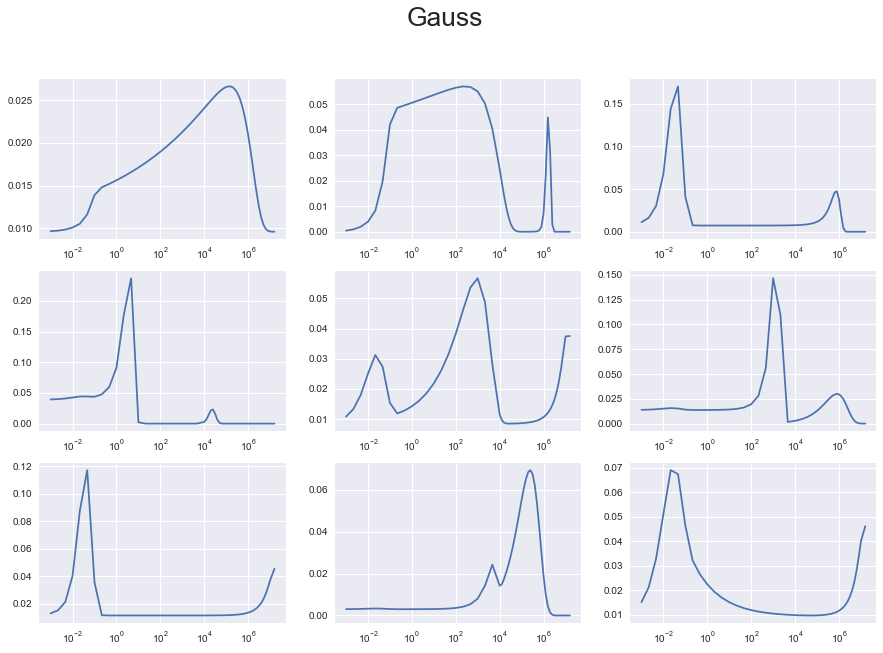

In [45]:
fig, axs = plt.subplots(3,3,figsize=(15,10))
for row in axs:
    for ax in row:
        ax.plot(Ebins, randGauss())
        ax.set_xscale("log")
        
plt.suptitle("Gauss")

Text(0.5, 0.98, 'Evap')

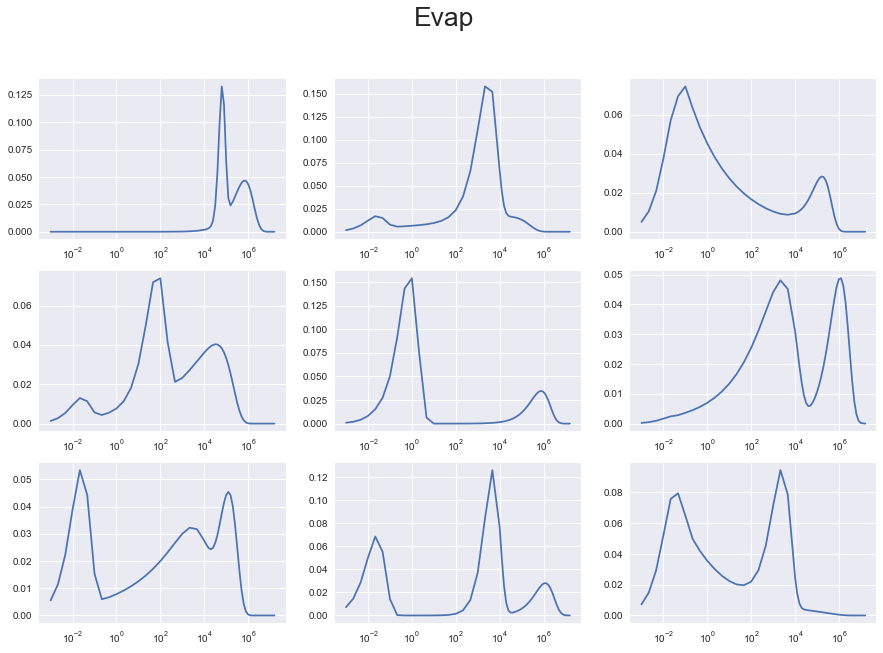

In [19]:
fig, axs = plt.subplots(3,3,figsize=(15,10))
for row in axs:
    for ax in row:
        ax.plot(Ebins, randEvap())
        ax.set_xscale("log")
        
plt.suptitle("Evap")

Text(0.5, 0.98, 'High Energy')

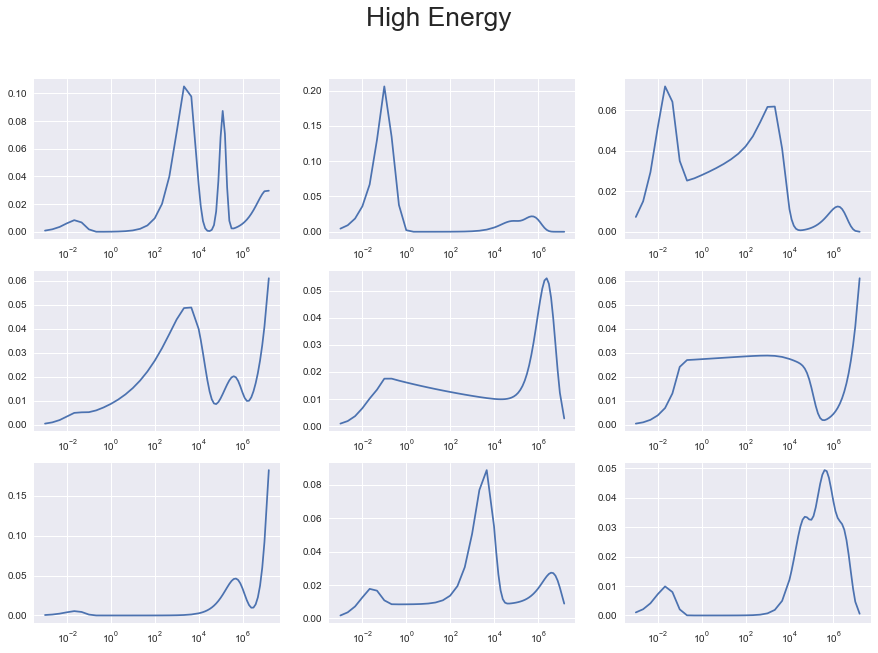

In [20]:
fig, axs = plt.subplots(3,3,figsize=(15,10))
for row in axs:
    for ax in row:
        ax.plot(Ebins, randHighEnergy())
        ax.set_xscale("log")
        
plt.suptitle("High Energy")

In [37]:
def randMonoGauss():
    E_m_rand = random.choice(E_m_gauss)
    sigma_rand = random.choice(sigma_gauss)
    
    if sigma_rand > E_m_rand:
        return randMonoGauss()
    
    return fast_gaussian(Ebins * 1e-6, E_m_rand, sigma_rand)

Text(0.5, 0.98, 'Mono Gauss')

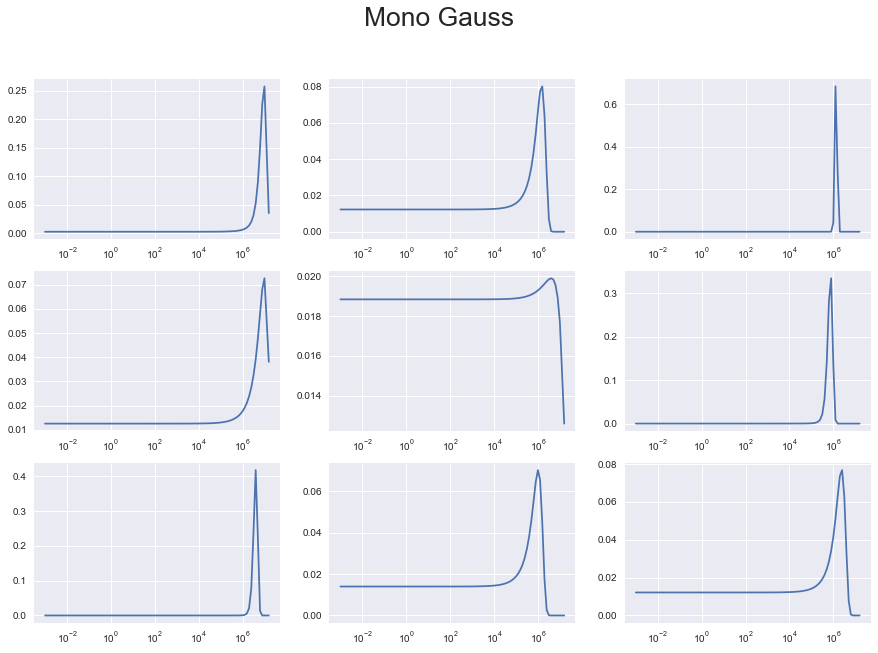

In [39]:
fig, axs = plt.subplots(3,3,figsize=(15,10))
for row in axs:
    for ax in row:
        ax.plot(Ebins, randMonoGauss())
        ax.set_xscale("log")
        
plt.suptitle("Mono Gauss")

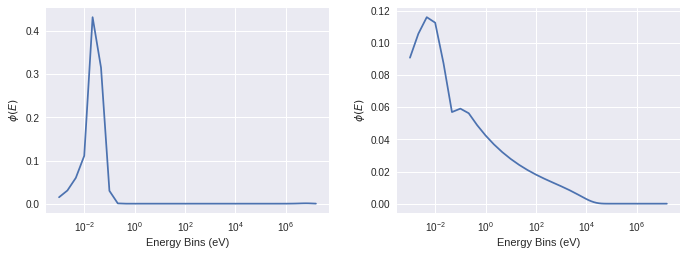

In [40]:
fig, axs = plt.subplots(1, 2,  figsize = (10,16/4))

axs[0].plot(constants.Ebins, randFission())
axs[0].set_xscale("log")
axs[0].set_xlabel("Energy Bins (eV)")
axs[0].set_ylabel("$\phi(E)$")

axs[1].plot(constants.Ebins, randFission())
axs[1].set_xscale("log")
axs[1].set_xlabel("Energy Bins (eV)")
axs[1].set_ylabel("$\phi(E)$")

plt.tight_layout()
plt.savefig("fission_EX", dpi = 300)

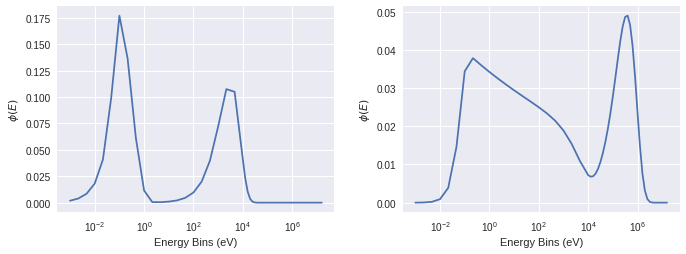

In [41]:
fig, axs = plt.subplots(1, 2,  figsize = (10,16/4))

axs[0].plot(constants.Ebins, randEvap())
axs[0].set_xscale("log")
axs[0].set_xlabel("Energy Bins (eV)")
axs[0].set_ylabel("$\phi(E)$")

axs[1].plot(constants.Ebins, randEvap())
axs[1].set_xscale("log")
axs[1].set_xlabel("Energy Bins (eV)")
axs[1].set_ylabel("$\phi(E)$")

plt.tight_layout()
plt.savefig("evap_EX", dpi = 300)

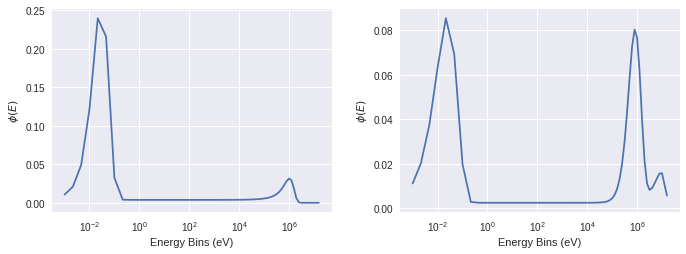

In [42]:
fig, axs = plt.subplots(1, 2,  figsize = (10,16/4))

axs[0].plot(constants.Ebins, randGauss())
axs[0].set_xscale("log")
axs[0].set_xlabel("Energy Bins (eV)")
axs[0].set_ylabel("$\phi(E)$")

axs[1].plot(constants.Ebins, randGauss())
axs[1].set_xscale("log")
axs[1].set_xlabel("Energy Bins (eV)")
axs[1].set_ylabel("$\phi(E)$")

plt.tight_layout()
plt.savefig("gauss_EX", dpi = 300)

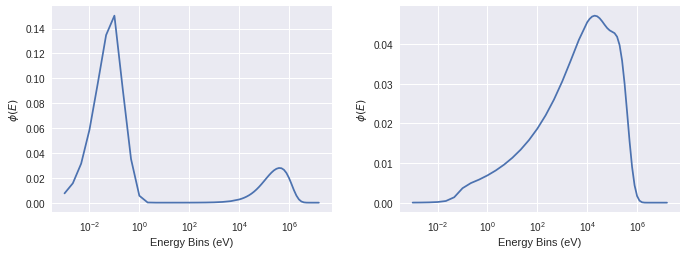

In [43]:
fig, axs = plt.subplots(1, 2,  figsize = (10,16/4))

axs[0].plot(constants.Ebins, randHighEnergy())
axs[0].set_xscale("log")
axs[0].set_xlabel("Energy Bins (eV)")
axs[0].set_ylabel("$\phi(E)$")

axs[1].plot(constants.Ebins, randHighEnergy())
axs[1].set_xscale("log")
axs[1].set_xlabel("Energy Bins (eV)")
axs[1].set_ylabel("$\phi(E)$")

plt.tight_layout()
plt.savefig("high_energy_EX", dpi = 300)